In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
import graphufs
plt.style.use("graphufs.plotstyle")

/home/tsmith/work/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [3]:
ds = xr.concat(
    [
        xr.open_zarr(
            f"gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.statistics.1993-2019/{component}_by_level.zarr",
            storage_options={"token": "anon"}
        ).expand_dims(
            {"comp": [component]},
        )[["tmp", "spfh", "ugrd", "vgrd", "dzdt","delz"]]
        for component in ["mean", "stddev", "diffs_stddev"]
    ],
    dim="comp",
)

In [4]:
ds.load();

In [16]:
def plot(
    comp,
    n_interfaces,
):
    vlist = ["tmp", "spfh", "ugrd", "vgrd", "dzdt"]
    ncols = len(vlist)
    fig, axs = plt.subplots(1, ncols, figsize=(4*ncols, 5), constrained_layout=True, sharey=True)

    n_top = n_interfaces//4+1
    n_middle = n_interfaces//4
    n_bottom = 2*n_interfaces//4
    print(n_top, n_middle, n_bottom, n_top + n_middle + n_bottom)
    knots = [200, 360, 800, 1000]
    interfaces = np.concatenate(
        list(
            [
                np.linspace(knots[0], knots[1], n_top),
                np.linspace(knots[1], knots[2], n_middle+1)[1:],
                np.linspace(knots[2], knots[3], n_bottom+1)[1:],
            ]
        )
    )
    print(interfaces, len(interfaces))
    nds = graphufs.fvemulator.fv_vertical_regrid(
        ds,
        interfaces,
    )
    
    for v, ax in zip(vlist, axs):
        for xds in [ds, nds]:
            plotme = xds[v].sel(comp=comp)
            plotme.plot(ax=ax, y="pfull", marker="o")
        ax.set(
            ylabel="pfull" if ax.get_subplotspec().is_first_col() else "",
            title="",
            ylim=(interfaces[-1], interfaces[0]),
            yticks=interfaces,
        )
        ax.grid(True)
    fig.suptitle(comp)
    return fig, axs

5 4 8 17
[ 200.  240.  280.  320.  360.  470.  580.  690.  800.  825.  850.  875.
  900.  925.  950.  975. 1000.] 17
5 4 8 17
[ 200.  240.  280.  320.  360.  470.  580.  690.  800.  825.  850.  875.
  900.  925.  950.  975. 1000.] 17
5 4 8 17
[ 200.  240.  280.  320.  360.  470.  580.  690.  800.  825.  850.  875.
  900.  925.  950.  975. 1000.] 17


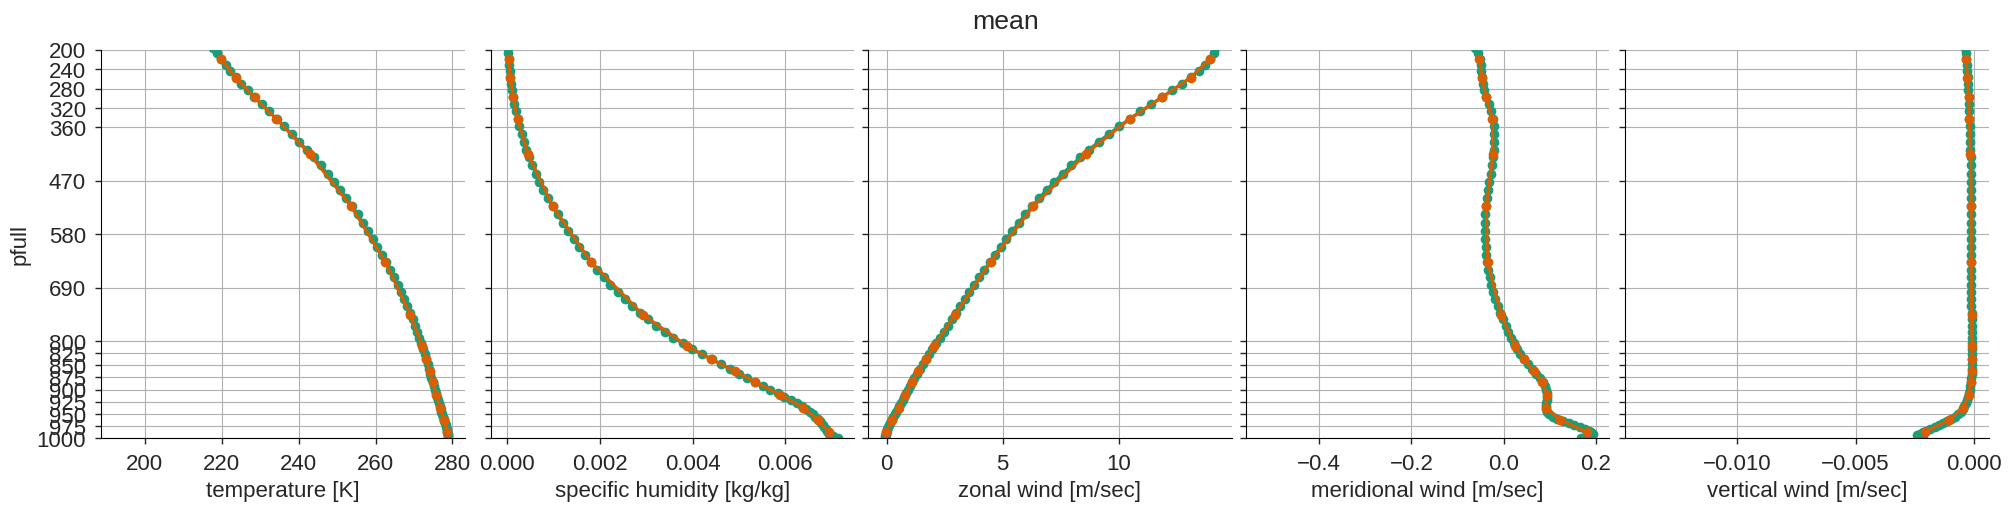

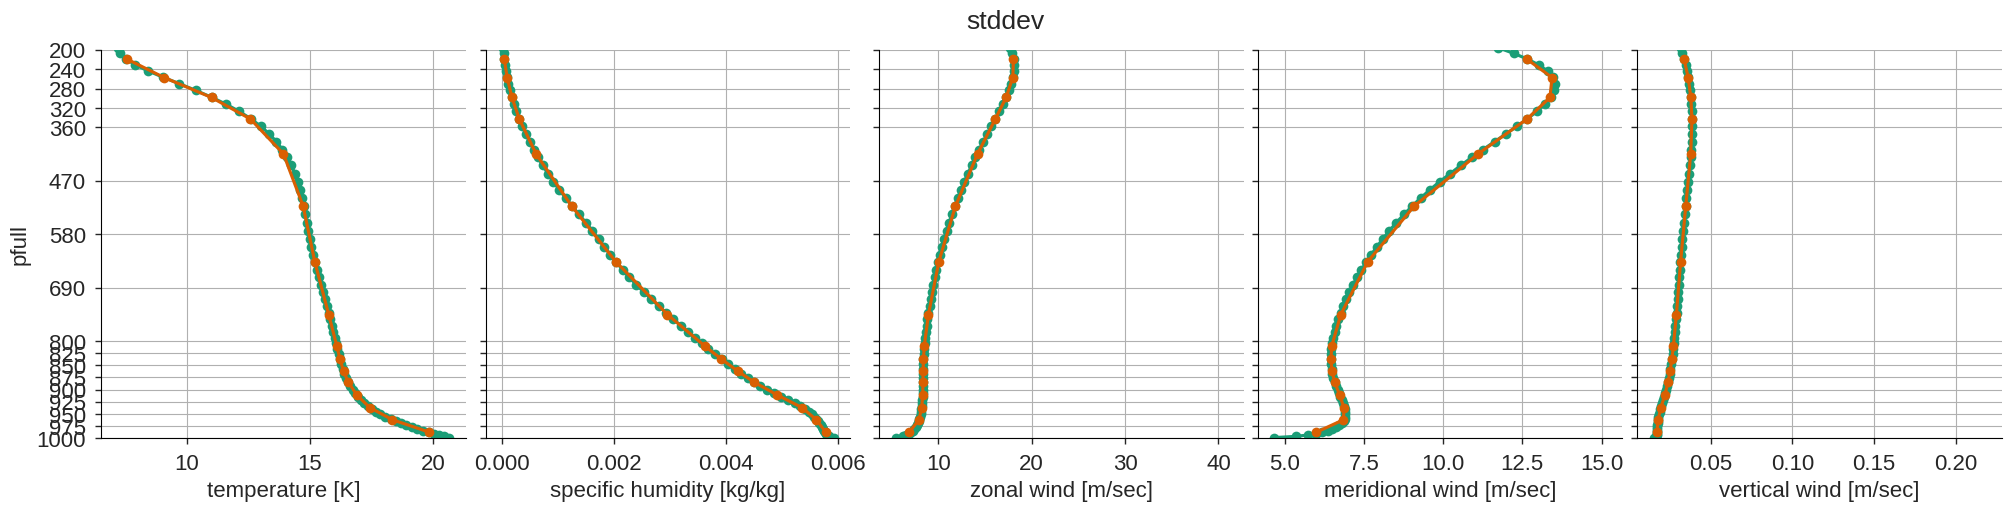

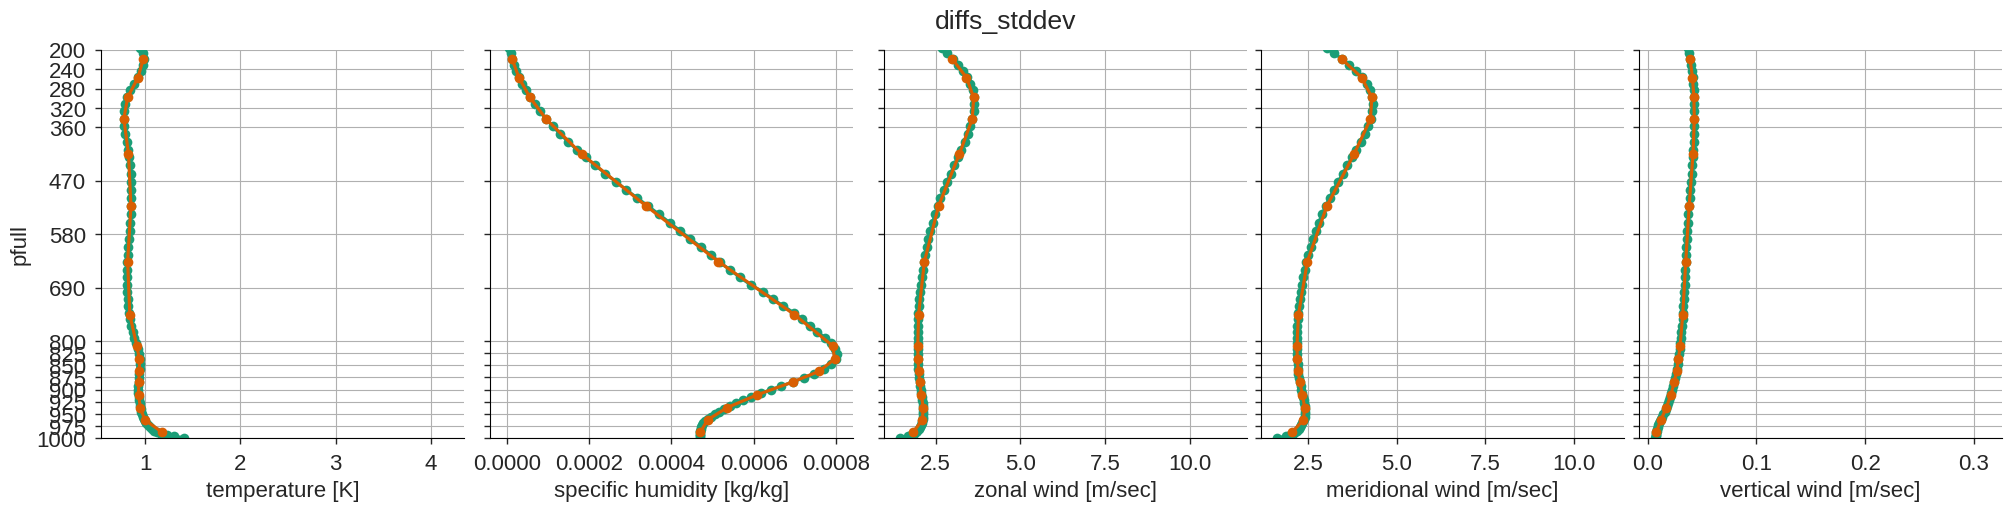

In [22]:
n=17
plot("mean", n);
plot("stddev", n);
plot("diffs_stddev", n);

4 3 6 13
[ 200.          253.33333333  306.66666667  360.          506.66666667
  653.33333333  800.          833.33333333  866.66666667  900.
  933.33333333  966.66666667 1000.        ] 13
4 3 6 13
[ 200.          253.33333333  306.66666667  360.          506.66666667
  653.33333333  800.          833.33333333  866.66666667  900.
  933.33333333  966.66666667 1000.        ] 13
4 3 6 13
[ 200.          253.33333333  306.66666667  360.          506.66666667
  653.33333333  800.          833.33333333  866.66666667  900.
  933.33333333  966.66666667 1000.        ] 13


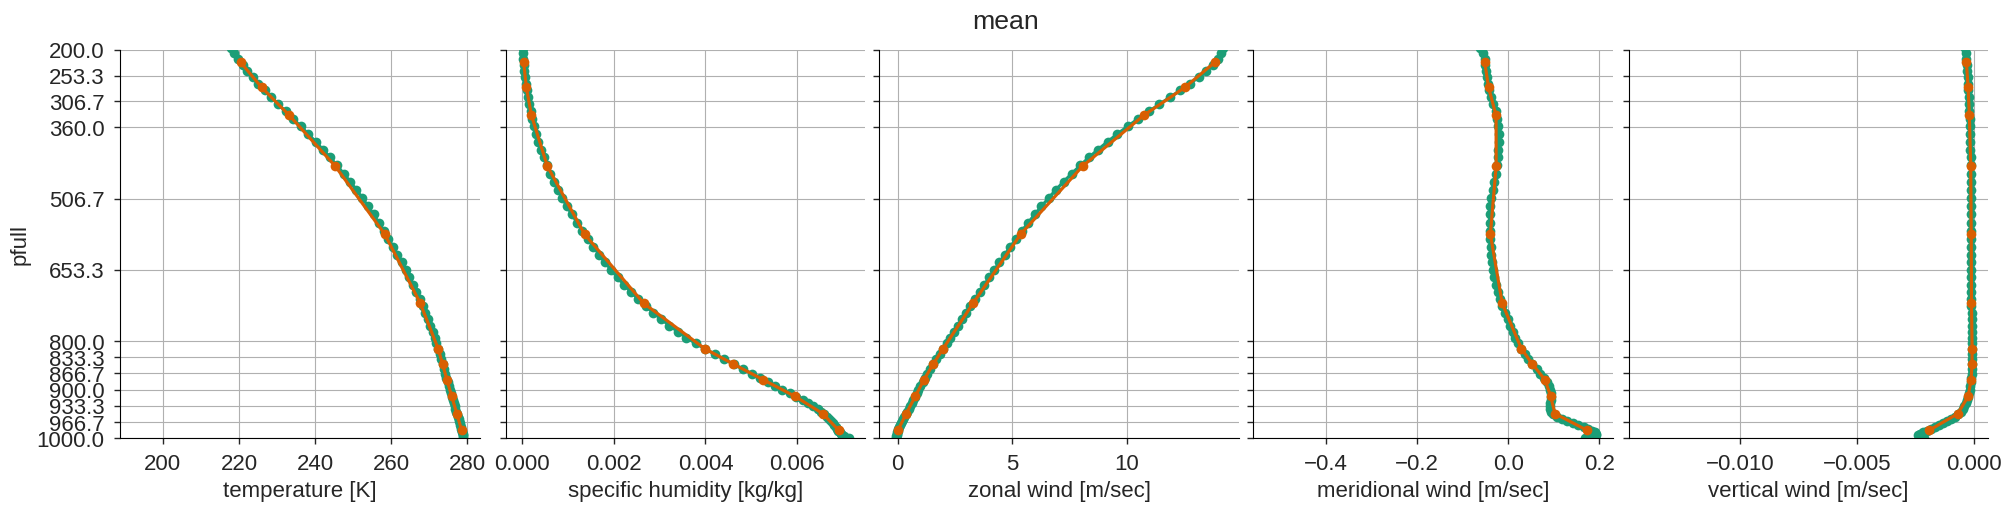

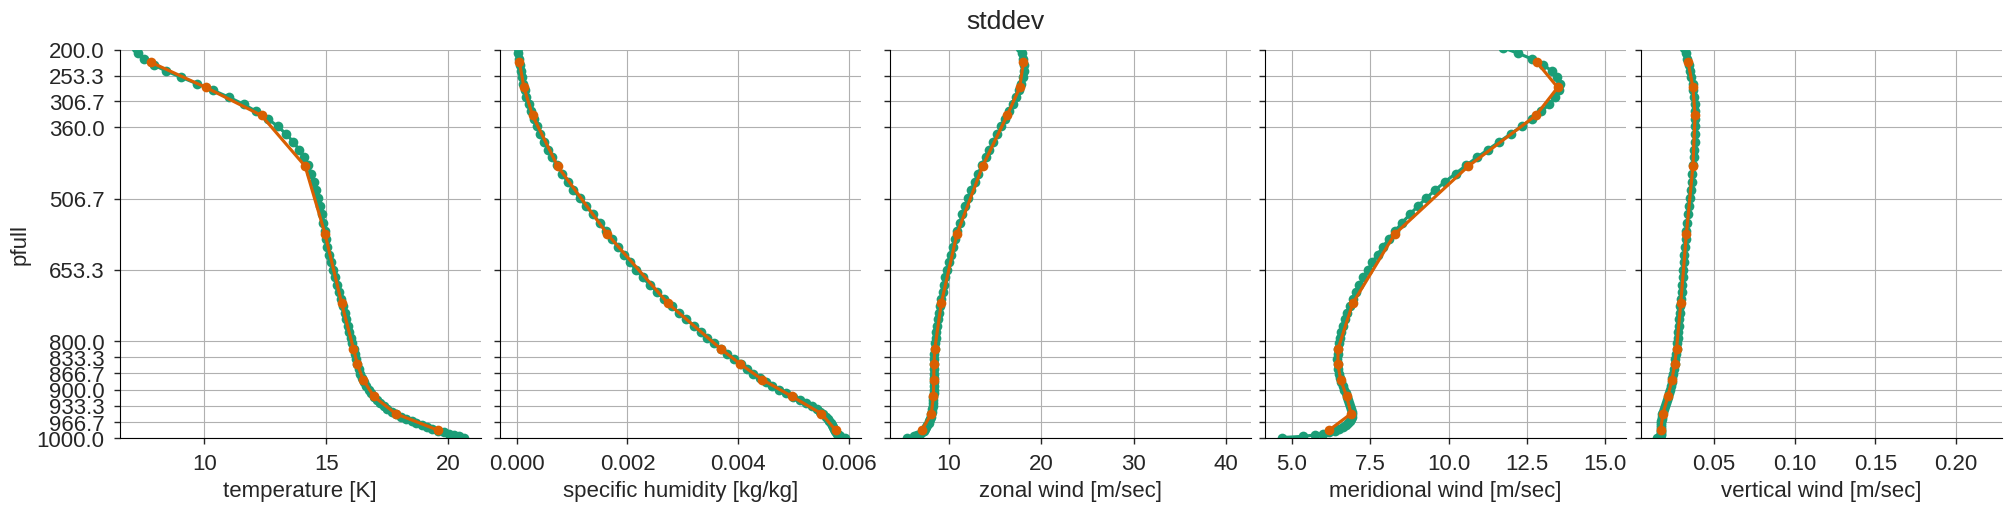

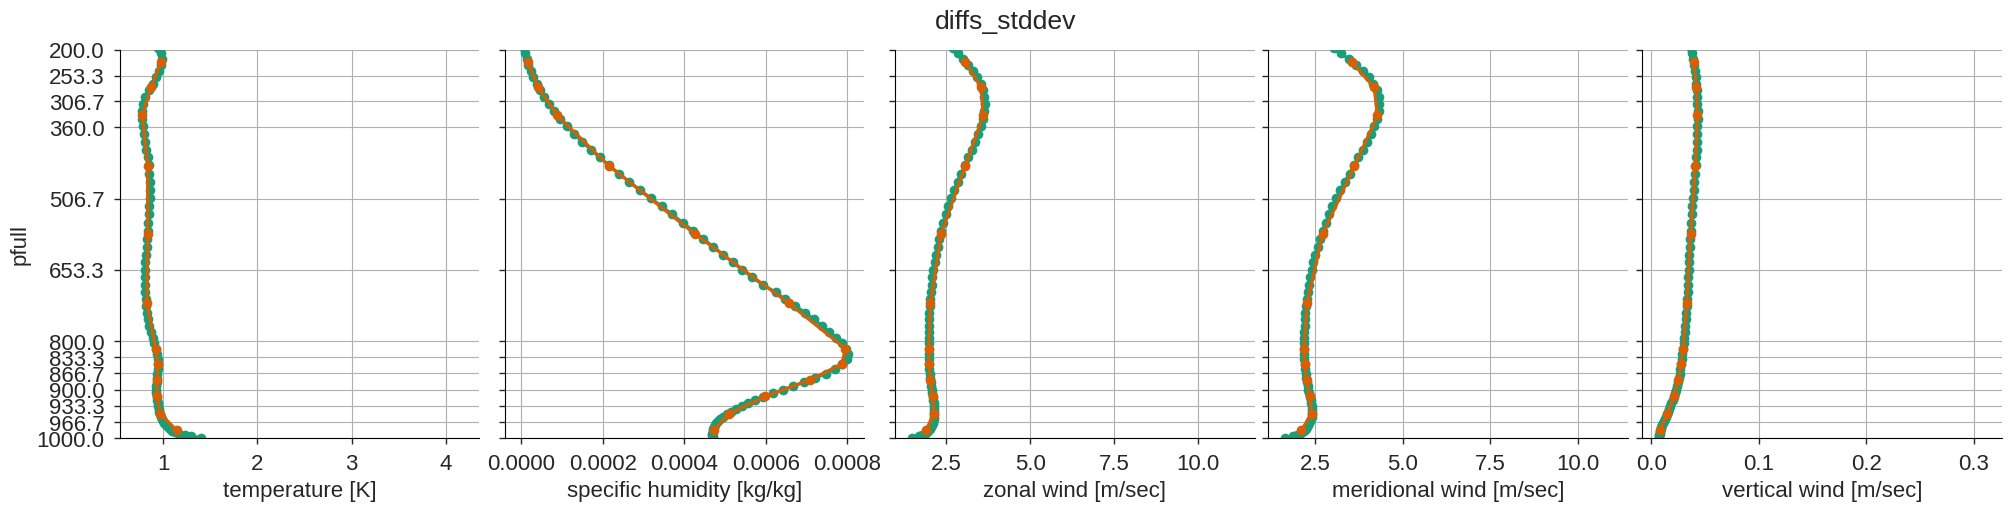

In [23]:
n=13
plot("mean", n);
plot("stddev", n);
plot("diffs_stddev", n);

3 2 4 9
[ 200.  280.  360.  580.  800.  850.  900.  950. 1000.] 9
3 2 4 9
[ 200.  280.  360.  580.  800.  850.  900.  950. 1000.] 9
3 2 4 9
[ 200.  280.  360.  580.  800.  850.  900.  950. 1000.] 9


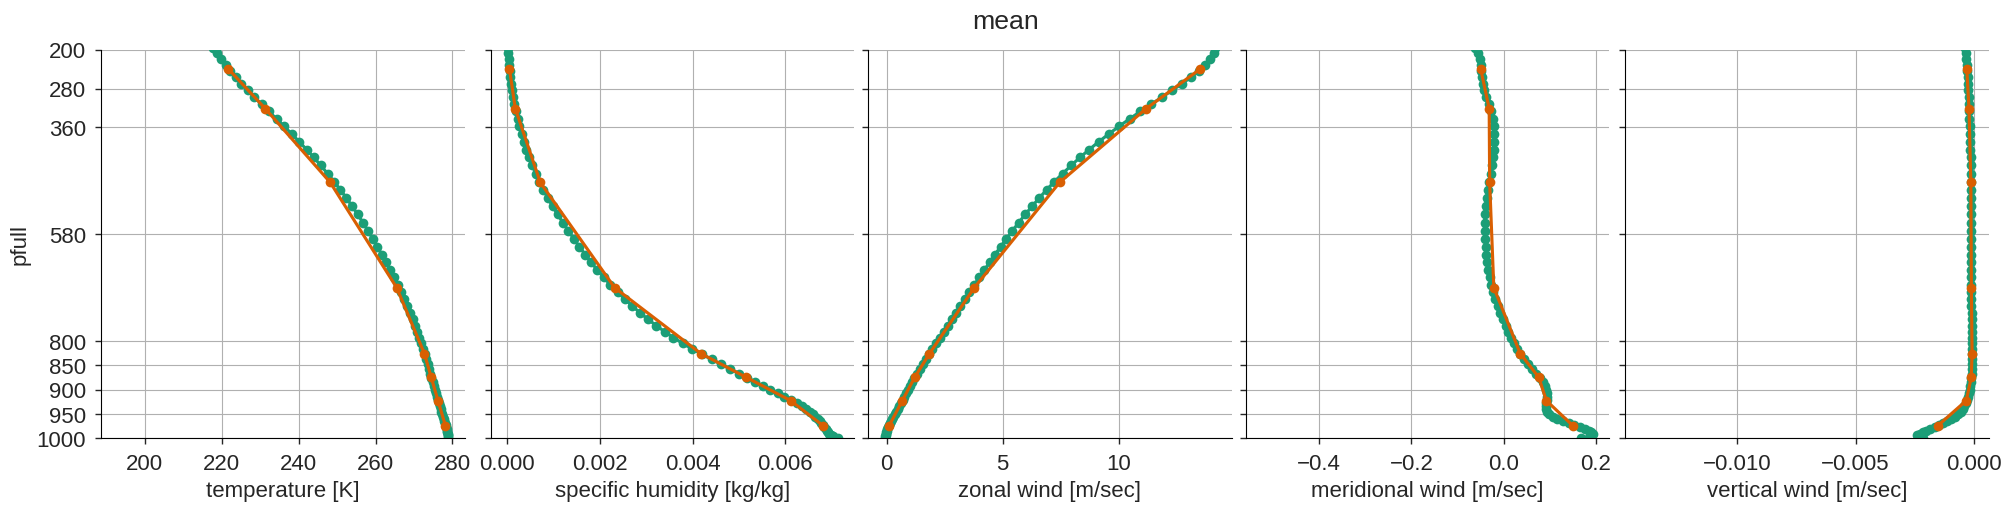

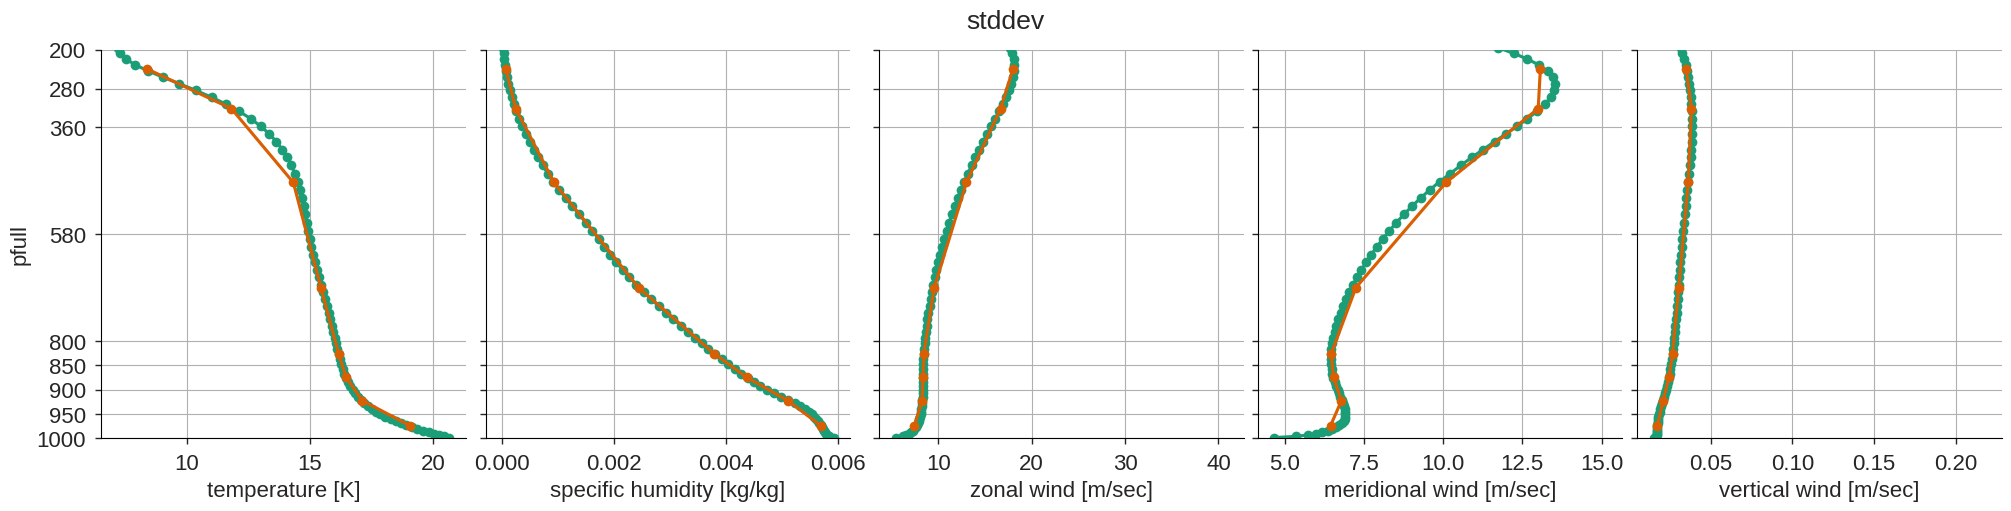

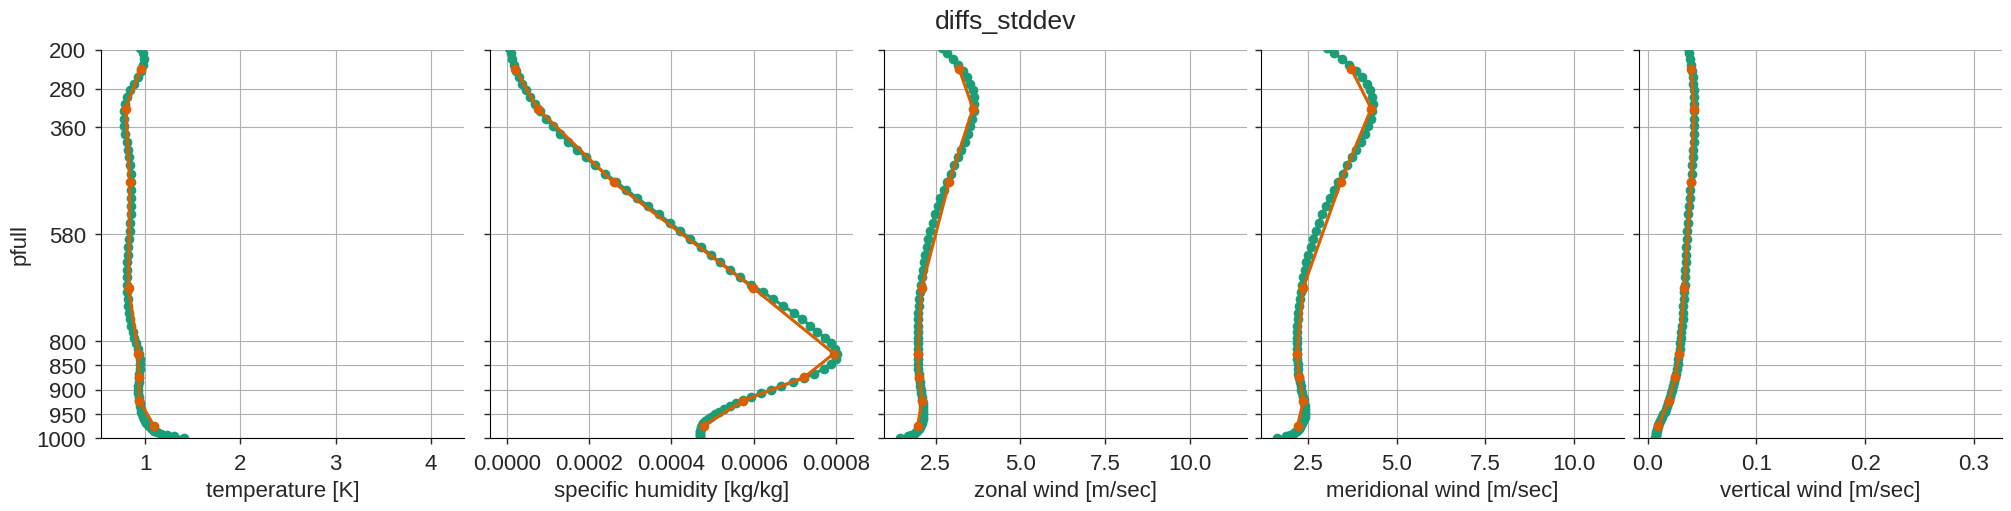

In [24]:
n=9
plot("mean", n);
plot("stddev", n);
plot("diffs_stddev", n);

In [137]:
1.25 / .29

4.166666666666667

In [172]:
from graphufs.fvemulator import get_new_vertical_grid
def fv_vertical_regrid_cost(xds, interfaces, keep_delz=False):
    """Vertically regrid a dataset based on approximately located interfaces
    by "approximately" we mean to grab the nearest neighbor to the values in interfaces

    Args:
        xds (xr.Dataset)
        interfaces (array_like)

    Returns:
        nds (xr.Dataset): with vertical averaging
    """
    # create a new dataset with the new vertical grid
    nds = get_new_vertical_grid(interfaces)


    # if the dataset has somehow already renamed pfull -> level, rename to pfull for Layers2Pressure computations
    has_level_not_pfull = False
    if "level" in xds.dims and "pfull" not in xds.dims:
        with xr.set_options(keep_attrs=True):
            xds = xds.rename({"pfull": "level"})

    # Regrid vertical distance, and get weighting
    delz = np.abs(xds["delz"].groupby_bins(
        "pfull",
        bins=nds["phalf"],
    ).sum())
    count = xds["delz"].groupby_bins(
        "pfull",
        bins=nds["phalf"],
    ).count()
    new_delz_inverse = 1/delz

    # Do the regridding
    vars2d = [x for x in xds.data_vars if "pfull" not in xds[x].dims]
    vars3d = [x for x in xds.data_vars if "pfull" in xds[x].dims and x != "delz"]
    for key in vars3d:
        with xr.set_options(keep_attrs=True):
            nds[key] = count * new_delz_inverse * (
                (
                    xds[key]*xds["delz"]
                ).groupby_bins(
                    "pfull",
                    bins=nds["phalf"],
                ).var()
            )
        nds[key].attrs = xds[key].attrs.copy()

    nds = nds.set_coords("pfull")
    nds["pfull_bins"] = nds["pfull_bins"].swap_dims({"pfull_bins": "pfull"})
    for key in vars3d:
        with xr.set_options(keep_attrs=True):
            nds[key] = nds[key].swap_dims({"pfull_bins": "pfull"})
        nds[key].attrs["regridding"] = "delz weighted average in vertical, new coordinate bounds represented by 'phalf'"
    for v in vars2d:
        nds[v] = xds[v]

    if keep_delz:
        delz = delz.swap_dims({"pfull_bins": "pfull"})
        nds["delz"] = delz

    # unfortunately, cannot store the pfull_bins due to this issue: https://github.com/pydata/xarray/issues/2847
    nds = nds.drop_vars("pfull_bins")
    return nds

In [198]:
def cost_per_component(interfaces, xds):

    nds = fv_vertical_regrid_cost(
        xds,
        interfaces,
    )
    xtds = xds.sel(pfull=slice(interfaces[0], interfaces[-1]))
    cost = 0
    cost_per_var = {}
    for v in nds.data_vars:
        cpv = np.sqrt(np.mean(nds[v].values))
        cpv = (cpv - xtds[v].mean())/xtds[v].std()
        cpv = cpv.values
        cpv = cpv**2
        cost += cpv
        cost_per_var[v] = cpv

    return cost, cost_per_var

In [199]:
c, cv = cost_per_component(
    interfaces=np.linspace(200, 1000, 17),
    xds=ds[["delz", "tmp", "spfh", "ugrd", "vgrd", "dzdt"]].sel(comp="mean"),
)

In [210]:
def total_cost(interfaces):
    vlist = ["delz", "tmp", "spfh", "ugrd", "vgrd", "dzdt"]
    the_total_cost = 0.
    total_cost_per_var = {k: 0. for k in vlist}
    for component in ds.comp.values:
        c, cv = cost_per_component(
            interfaces=interfaces,
            xds=ds[vlist].sel(comp=component),
        )
        the_total_cost += c
        for key, val in cv.items():
            total_cost_per_var[key] += val
    return the_total_cost
        

In [211]:
tc = total_cost(np.linspace(200, 1000, 17))

In [212]:
from scipy.optimize import minimize

In [213]:
minimize?

Signature:
minimize(
    fun,
    x0,
    args=(),
    method=None,
    jac=None,
    hess=None,
    hessp=None,
    bounds=None,
    constraints=(),
    tol=None,
    callback=None,
    options=None,
)
Docstring:
Minimization of scalar function of one or more variables.

Parameters
----------
fun : callable
    The objective function to be minimized.

        ``fun(x, *args) -> float``

    where ``x`` is a 1-D array with shape (n,) and ``args``
    is a tuple of the fixed parameters needed to completely
    specify the function.
x0 : ndarray, shape (n,)
    Initial guess. Array of real elements of size (n,),
    where ``n`` is the number of independent variables.
args : tuple, optional
    Extra arguments passed to the objective function and its
    derivatives (`fun`, `jac` and `hess` functions).
method : str or callable, optional
    Type of solver.  Should be one of

        - 'Nelder-Mead' :ref:`(see here) <optimize.minimize-neldermead>`
        - 'Powell'      :ref:`(see here) <

In [223]:
%%time
optimal_interfaces = minimize(
    total_cost,
    x0=np.linspace(200, 1000, 9),
    bounds=[(200, 1000)]*9,
)

CPU times: user 1.57 s, sys: 17.8 ms, total: 1.59 s
Wall time: 1.6 s


In [225]:
optimal_interfaces

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 110.54930321381183
        x: [ 2.000e+02  3.000e+02  4.000e+02  5.000e+02  6.000e+02
             7.000e+02  8.000e+02  9.000e+02  1.000e+03]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00  0.000e+00 -0.000e+00]
     nfev: 10
     njev: 1
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>

In [208]:
tc

164.70960281510534

In [209]:
tcv

{'delz': 0.0,
 'tmp': 106.83824469910783,
 'spfh': 4.600885020521693,
 'ugrd': 20.487283161015,
 'vgrd': 18.059607952292573,
 'dzdt': 14.723581982168248}

In [163]:
cv

{'dzdt': -3.295672995893961e-06}

In [ ]:

def plot(
    comp,
    n_interfaces,
):
    vlist = ["tmp", "spfh", "ugrd", "vgrd", "dzdt"]
    ncols = len(vlist)
    fig, axs = plt.subplots(1, ncols, figsize=(4*ncols, 5), constrained_layout=True, sharey=True)

    n_top = n_interfaces//4+2
    n_middle = n_interfaces//4
    n_bottom = 2*n_interfaces//4-1
    print(n_top, n_middle, n_bottom, n_top + n_middle + n_bottom)
    knots = [200, 360, 800, 1000]
    interfaces = np.concatenate(
        list(
            [
                np.linspace(knots[0], knots[1], n_top),
                np.linspace(knots[1], knots[2], n_middle+1)[1:],
                np.linspace(knots[2], knots[3], n_bottom+1)[1:],
            ]
        )
    )
    print(interfaces, len(interfaces))
    nds = graphufs.fvemulator.fv_vertical_regrid(
        ds,
        interfaces,
    )
    
    for v, ax in zip(vlist, axs):
        for xds in [ds, nds]:
            plotme = xds[v].sel(comp=comp)
            plotme.plot(ax=ax, y="pfull", marker="o")
        ax.set(
            ylabel="pfull" if ax.get_subplotspec().is_first_col() else "",
            title="",
            ylim=(interfaces[-1], interfaces[0]),
            yticks=interfaces,
        )
        ax.grid(True)
    fig.suptitle(comp)
    return fig, axs